# <center>Assignment 2: Convolutional Neural Network</center>
**<center>Deep Learning | Spring 2022 | Shahid Beheshti University</center>**


Welcome to the **second** programming assignment of the Deep Learning course. 

---

<b>overview</b>:

The goal of this assignment is to get you familiarized with convolutional neural networks. 

First, we will train a CNN model as our base model to solve the Image Colorization task. In general, Image Colorization is a difficult problem e.g. a grayscale image, may have several valid coloring images.

After training, we will add some configurations to it to check their effect and then analyze it.



---
<b>Submission tips</b>:

please review the notes of **this notebook** and whatever is in the **assignment file**.

You can implement other than functions that exist in PY files or change the structure of the notebook based on the given Questions.



<b> What these codes do (exist in PY files)</b>:

There are four PY files that are required to run the CNN.ipynb. Below, the functionality of each PY file are summarized, but more details are provided in the files themselves.

- utils.py: Contain several functions for data preprocessing.
- torch_helper.py: Contain several functions used during the training process. `some of them required to implement`
- model.py: Contains several classes as the models and their blocks (base model and custom U-Net). `required to implement`
- train.py: as the its name show it is for training and validating model. `required to implement`


----
<b>Due date:</b> 10 Ordibehesht 1401 - 11:59 pm
 

 > **_NOTE:_** Alongside the `CNN.ipynb` notebook, there are some python files with the coding parts you need to implement are denoted by: ``` # YOUR CODE #```. Moreover, some <u>Questions</u> are given in the assignment file. 
 
 
 ---


<p style="color:red;">! Probably you need GPU to train your model so you may use your graphic of your system or if you are on Colab don't forget to enable that:</p>
<b><blockquote>Runtime -> Change runtime type -> Hardware Accelator: GPU</blockquote>


# Packages and modules

Let's first import all the packages that you will need during this assignment.

In [ ]:
from google.colab import drive
 
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Pytorch library and other packages
import torch


# Constants

In [ ]:
colours_dic_addr = '/content/drive/MyDrive/deep/car_colours_kmeans24.npy'
your_student_id = 400443232

# Utils.py


In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import pickle
import sys
from urllib.error import *


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    # 50000 training set
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    # 10000 test set
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)


def get_file(fname,
             origin,
             untar=False,
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)

    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    return fpath


def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def rgb2label(rgb_images, colours, batch_size):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _rgb2label

    Args:
      rgb_images: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
      batch_size: int value to determine size of batch
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(rgb_images)[0] < batch_size:
        return _rgb2label(rgb_images)
    nexts = []
    for i in range(0, np.shape(rgb_images)[0], batch_size):
        next = _rgb2label(rgb_images[i:i + batch_size, :, :, :], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result


def _rgb2label(rgb_images, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `rgb_images`. This function is a little memory
    intensive, and so the size of `rgb_images` should not be too large.

    Args:
      rgb_images: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    rgb_images = np.expand_dims(rgb_images, 0)
    cs = np.reshape(colours, [num_colours, 1, 3, 1, 1])
    # Calculate distance
    dists = np.linalg.norm(rgb_images - cs, axis=2)  # 2 = colour axis
    label = np.argmin(dists, axis=0)
    label = np.expand_dims(label, axis=1)
    return label


def cat2rgb(labels, colours):
    """
    Get RGB colours given the colour categories

    Args:
      labels: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[labels]


def process(xs, ys, category_id, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the car category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      category_id: int value as the id of each category in CIFAR10 dataset
      max_pixel: maximum pixel value in the original data
      downsize_input: boolean value
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == category_id)[0], :, :, :]
    np.random.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2),
                                        nn.Upsample(scale_factor=2),
                                        nn.Upsample(scale_factor=2))
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return xs, xs_downsized
    else:
        return xs, grey


def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs (10 samples you can change this value)

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10, :, :, :], [0, 2, 3, 1])
    gtcolor = cat2rgb(gtlabel[:10, 0, :, :], colours)
    predcolor = cat2rgb(output[:10, 0, :, :], colours)

    img_stack = [
        np.hstack(np.tile(grey, [1, 1, 1, 3])),
        np.hstack(gtcolor),
        np.hstack(predcolor)]

    if compare_bilinear:
        downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                        nn.AvgPool2d(2),
                                        nn.Upsample(scale_factor=2, mode='bilinear'),
                                        nn.Upsample(scale_factor=2, mode='bilinear'))
        gt_input = np.transpose(gtcolor, [0, 3, 1, 2, ])
        color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
        color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
        img_stack = [
            np.hstack(np.transpose(input[:10, :, :, :], [0, 2, 3, 1])),
            np.hstack(gtcolor),
            np.hstack(predcolor),
            np.hstack(color_bilinear)]
    img = np.vstack(img_stack)

    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
        plt.show()
    else:
        plt.savefig(path)


# torch_helper.py

In [ ]:
from torch.autograd import Variable


# You can add any function here if needed in the training process

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i + batch_size, :, :, :]
        batch_y = y[i:i + batch_size, :, :, :]
        yield batch_x, batch_y


def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tensor): greyscale input
      ys (int numpy tensor): categorical labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)


# You can implement the model evaluation process in this function
def run_validation_step(args,test_grey, test_rgb_cat,model,criterion):
    ##############################################################################################
    valid_epoch_loss = 0.0
    valid_acc = 0.0
    total_valid = 0
    correct_valid = 0

    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                               test_rgb_cat,
                                               args.batch_size)):
            
            images, labels = get_torch_vars(xs, ys, args.gpu)

            output = model(images)        
            loss = compute_loss(criterion, output, labels, args.num_colors)
   
            valid_epoch_loss += loss.item()
            _, predicted = torch.max(output.data, 1, keepdim=True)
            total_valid += labels.size(0) * 32 * 32
            correct_valid += (predicted == labels.data).sum()      
    n_valid_batch = i
    valid_epoch_loss = valid_epoch_loss / n_valid_batch
    valid_acc = 100 * correct_valid / total_valid
    return  valid_epoch_loss, valid_acc
    ##############################################################################################
    


# Model.py

In [ ]:
import torch.nn as nn

device = torch.device('cuda:0')

class DownConv(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels, num_filters
    ):
        super(DownConv, self).__init__()
        padding = kernel // 2
        out_channels = int(out_channels/2)  
        self.down_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*2, kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            ]).to(device)
 
    def forward(self, x):
        ##############################################################################################
        for m in self.down_conv:
            x = m(x)
        return x
        ##############################################################################################
      

class UpConv(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels,num_colors, num_filters
    ):
        super(UpConv, self).__init__()
        padding = kernel // 2
        self.up_conv = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Conv2d(out_channels, num_colors, kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_colors),
            nn.ReLU(),
            nn.Conv2d(num_colors, num_colors, kernel, padding=padding)
            ]).to(device)
        

    def forward(self, x):
        ##############################################################################################
        for m in self.up_conv:
            x = m(x)
        return x
        ##############################################################################################



class Bottleneck(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels, num_filters
    ):
        super(Bottleneck, self).__init__()
        padding = kernel // 2
        self.bottle_neck = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            ]).to(device)

    def forward(self, x):
        ##############################################################################################
        for m in self.bottle_neck:
            x = m(x)
        return x
        ##############################################################################################


class BaseModel(nn.Module):
    def __init__(
            self, num_filters, num_colors, kernel, in_channels=1
    ):
        super(BaseModel, self).__init__()  
        self.num_filters = num_filters 
        # kernel = 5, in_channels = 1 , out_channels=64, num_filters= 32 
        self.downs = DownConv(kernel= kernel, in_channels = in_channels , out_channels=self.num_filters*2, num_filters = self.num_filters )
        # kernel = 5, in_channels = 64, out_channels=64, num_filters= 64 
        self.bottle_neck = Bottleneck(kernel = kernel, in_channels = self.num_filters*2, out_channels=self.num_filters*2, num_filters= self.num_filters*2 )
        # kernel = 5, in_channels = 64, out_channels=32, num_colors= 10 
        self.ups = UpConv(kernel = kernel, in_channels =self.num_filters*2, out_channels=self.num_filters, num_colors= num_colors, num_filters=self.num_filters)
        # Other properties if needed

        # Down part of the model, bottleneck, Up part of the model, final conv
        ##############################################################################################
        self.layer_lists = [self.downs, self.bottle_neck, self.ups]
        ##############################################################################################

    def forward(self, x):
        ##############################################################################################
        for m in self.layer_lists:
          x = m(x)
        return x
        ##############################################################################################

class DownBlock(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels, num_filters
    ):
        super(DownBlock, self).__init__()
        padding = kernel // 2
        self.down_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.MaxPool2d(2),
            nn.ReLU(),
            ).to(device)
 
    def forward(self, x):
        ##############################################################################################
        for m in self.down_block:
            x = m(x)
        return x
        ##############################################################################################

class upBlock(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels, num_filters
    ):
        super(upBlock, self).__init__()
        padding = kernel // 2
        self.up_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.Upsample(scale_factor=2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            ).to(device)
        
 
    def forward(self, x):
        ##############################################################################################
        for m in self.up_block:
            x = m(x)
        return x
        ##############################################################################################

class finalConv(nn.Module):
    def __init__(
            self, kernel, in_channels, out_channels, num_colors
    ):
        super(finalConv, self).__init__()
        padding = kernel // 2
        self.final_conv = nn.Sequential(
            nn.Conv2d(num_colors + in_channels, out_channels, kernel, padding=padding)
            ).to(device)
        
 
    def forward(self, x):
        ##############################################################################################
        for m in self.final_conv:
            x = m(x)
        return x
        ##############################################################################################
      

class CustomUNET(nn.Module):
    def __init__(
            self, num_filters, num_colors, kernel, in_channels=1
    ):
        super(CustomUNET, self).__init__()

        self.ups = nn.ModuleList().to(device)
        self.downs = nn.ModuleList().to(device)
        # Other properties if needed

        # Down part of the model, bottleneck, Up part of the model, final conv
        ##############################################################################################
        self.down_1 = DownBlock(kernel= kernel, in_channels = in_channels , out_channels=num_filters, num_filters = num_filters )
        self.down_2 = DownBlock(kernel= kernel, in_channels = num_filters , out_channels=num_filters*2, num_filters = num_filters*2 )
        self.bottle_neck =  Bottleneck(kernel = kernel, in_channels = num_filters*2, out_channels= num_filters*2, num_filters= num_filters*2 )
        self.up_1 = upBlock(kernel= kernel, in_channels = num_filters*4 , out_channels=num_filters, num_filters = num_filters )
        self.up_2 = upBlock(kernel= kernel, in_channels = num_filters*2 , out_channels=num_colors, num_filters = num_colors )
        self.final = finalConv(kernel= kernel, in_channels =in_channels, num_colors = num_colors , out_channels=num_colors)
        # self.downs.append(down_1)
        # self.downs.append(down_2)
        # self.ups.append(up_1)
        # self.ups.append(up_2)
        ##############################################################################################

    def forward(self, x):
        ##############################################################################################
        self.out1 = self.down_1(x)
        self.out2 = self.down_2(self.out1)
        self.out3 = self.bottle_neck(self.out2)
        self.out4 = self.up_1(torch.cat((self.out3, self.out2), dim=1))
        self.out5 = self.up_2(torch.cat((self.out4, self.out1), dim=1))
        self.out6 = self.final(torch.cat((self.out5, x), dim=1))
        return self.out6
        ##############################################################################################
        None



In [ ]:
base_model = BaseModel(32, 24, 3)
print(base_model)

BaseModel(
  (downs): DownConv(
    (down_conv): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): ReLU()
    )
  )
  (bottle_neck): Bottleneck(
    (bottle_neck): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (ups): UpConv(
    (up_conv): ModuleList(
      (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1)

In [ ]:
unet_model = CustomUNET(32, 24, 3)
print(unet_model)

CustomUNET(
  (ups): ModuleList()
  (downs): ModuleList()
  (down_1): DownBlock(
    (down_block): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
  )
  (down_2): DownBlock(
    (down_block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU()
    )
  )
  (bottle_neck): Bottleneck(
    (bottle_neck): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (up_1): upBlock

# Dataset


## Prepare Dataset: cifar10

**CIFAR-10** is considered for this assignment which consists of images of size 32x32 pixels. For simplicity, one category of this dataset is considered (automobile).
The input and output of the network will be the grayscale image and RGB image respectively. by **running** the following code blocks get the dataset.

The subset of **24 colors** that are selected to colorize the grayscale images is provided in the car_colours_kmeans24.npy file.

In [ ]:
# Download CIFAR dataset
(x_train, y_train), (x_test, y_test) = load_cifar10()

# LOAD THE COLOURS CATEGORIES
colours = np.load(colours_dic_addr, allow_pickle=True, encoding='bytes')

# train.py

In [ ]:
pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=5f8d3ffa984db253184ecaae47d4f6da014b9b12f626b0471d966bc9dc5d898e
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchviz import make_dot

def compute_loss(criterion, outputs, labels, num_colors):

        
        num_samples = outputs.shape[0]
        
        outputs = outputs.transpose(1, 3).contiguous()
        labels = labels.transpose(1, 3).contiguous()

        
        outputs = outputs.view([num_samples * 32 * 32, num_colors])
        
        labels = labels.view([num_samples * 32 * 32])        
        
        return criterion(outputs, labels)

def train(args):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    #####################################################################################
    # TODO: Implement this function to train model and consider the below items         #
    # 0. read the utils file and use 'process' and 'get_rgb_cat' to get x and y for     #
    #    test and train dataset                                                         #
    # 1. Create train and test data loaders with respect to some hyper-parameters       #
    # 2. Get an instance of your 'model_mode' based on 'model_mode==base' or            #
    #    'model_mode==U-Net'.                                                           #
    # 3. Define an appropriate loss function (cross entropy loss)                       #
    # 4. Define an optimizers with proper hyper-parameters such as (learning_rate, ...).#
    # 5. Implement the main loop function with n_epochs iterations which the learning   #
    #    and evaluation process occurred there.                                         #
    # 6. Save the model weights                                                         #
    # Hint: Modify the predicted output form the model, to use loss function in step 3  #
    #####################################################################################
    """
    Train the model
    
    Args:
     model_mode: String
    Returns:
      model: trained model
    """
    torch.set_num_threads(5)

    # Numpy random seed
    np.random.seed(args.seed)

    # Save directory
    save_dir = "/content/drive/MyDrive/deep/outputs/" + args.experiment_name

    # default `log_dir` 
    writer = SummaryWriter('/content/drive/MyDrive/deep/runs/'+ args.experiment_name )

    # Download CIFAR dataset
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours_dic_addr,  allow_pickle=True, encoding='bytes')

    print("Transforming data...")
    # Get X(grayscale images) and Y(the nearest Color to each pixel based on given color dictionary)
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input, category_id=args.category_id)
    train_rgb_cat = rgb2label(train_rgb, colours, args.batch_size)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input, category_id=args.category_id)
    test_rgb_cat = rgb2label(test_rgb, colours, args.batch_size)

    # LOAD THE MODEL
    ##############################################################################################
    if args.model_mode == 'base':
      model = BaseModel(args.num_filters, args.num_colors, args.kernel)
    elif  args.model_mode == 'unet': 
      model = CustomUNET(args.num_filters, args.num_colors, args.kernel)
    ##############################################################################################

    # LOSS FUNCTION and Optimizer
    ##############################################################################################
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    ##############################################################################################

    # Create the outputs' folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    train_losses = []
    valid_losses = []
    valid_accs = []
    train_accs = []

    # Early stopping
    last_loss = 100
    patience = 2
    triggertimes = 0

    # Training loop
    for epoch in range(args.epochs):
        train_epoch_loss = 0.0
        train_acc = 0.0
        total_train = 0
        correct_train = 0

        # Train the Model
        model.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            # Convert numpy array to pytorch tensors
            images, labels = get_torch_vars(xs, ys, args.gpu)


            # Forward + Backward + Optimize
            ##############################################################################################
            optimizer.zero_grad()
        
            output = model(images)    
            make_dot(output, params=dict(list(model.named_parameters()))).render(args.experiment_name, format="png")    

            loss = compute_loss(criterion, output, labels, args.num_colors)
            
            loss.backward()    
            optimizer.step()    
            train_epoch_loss += loss.item()
            _, predicted = torch.max(output.data, 1, keepdim=True)
            total_train += labels.size(0) * 32 * 32
            correct_train += (predicted == labels.data).sum()
            ##############################################################################################

        # Calculate and Print training loss for each epoch
        ##############################################################################################
        n_training_batch = i
        train_epoch_loss = train_epoch_loss / n_training_batch
        train_losses.append(train_epoch_loss)
        train_acc = 100 * correct_train / total_train
        train_accs.append(train_acc)
        writer.add_scalar('Train Loss', train_epoch_loss, epoch)
        writer.add_scalar('Train Accuracy', train_acc, epoch)
        if epoch % args.print_every == 0:
          print(
              'Epoch [{}/{}]:\t Train Loss: {:.4f}, Train accuracy: {:.4f}'.format(
                  epoch + 1,
                  args.epochs,
                  train_epoch_loss,
                  train_acc)) 
        if args.plot:
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)
        ##############################################################################################

        # Evaluate the model
        ##############################################################################################
        model.eval()
        val_loss, val_acc = run_validation_step(args,test_grey, test_rgb_cat,model,criterion)
        ##############################################################################################

        # Calculate and Print (validation loss, validation accuracy) for each epoch
        ##############################################################################################
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        writer.add_scalar('Valid Loss', val_loss, epoch)
        writer.add_scalar('Valid Accuracy', val_acc, epoch)
        if epoch % args.print_every == 0:
          print(
              'Epoch [{}/{}]:\t Valid Loss: {:.4f}, Valid accuracy: {:.4f}'.format(
                  epoch + 1,
                  args.epochs,
                  val_loss,
                  val_acc))
        ##############################################################################################
        if val_loss > last_loss:
            trigger_times += 1
            print('The Last Loss: ', last_loss, ' The Current Loss: ',val_loss )
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = val_loss
    
    # Plot training-validation curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(model.state_dict(), args.checkpoint)

    return model


# Image Colorization 

## Base Model

### Training

File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Epoch [1/50]:	 Train Loss: 3.0059, Train accuracy: 13.9022
Epoch [1/50]:	 Valid Loss: 3.0543, Valid accuracy: 20.8192
Epoch [6/50]:	 Train Loss: 2.1666, Train accuracy: 31.9023
Epoch [6/50]:	 Valid Loss: 2.3070, Valid accuracy: 33.3040
Epoch [11/50]:	 Train Loss: 1.9592, Train accuracy: 35.8226
Epoch [11/50]:	 Valid Loss: 2.1020, Valid accuracy: 37.2719
Epoch [16/50]:	 Train Loss: 1.8614, Train accuracy: 37.7729
Epoch [16/50]:	 Valid Loss: 2.0012, Valid accuracy: 39.1037
Epoch [21/50]:	 Train Loss: 1.8019, Train accuracy: 38.9653
Epoch [21/50]:	 Valid Loss: 1.9400, Valid accuracy: 40.1409
Epoch [26/50]:	 Train Loss: 1.7608, Train accuracy: 39.7873
Epoch [26/50]:	 Valid Loss: 1.8987, Valid accuracy: 40.8845
Epoch [31/50]:	 Train Loss: 1.7301, Train accuracy: 40.4294
Epoch [31/50]:	 Valid Loss: 1.8686, Valid accuracy: 41.4086
Epoch [36/50]:	 Train Loss: 1.7057, Train accuracy: 40.9512
Epoch [36/50]:	 Valid Loss: 1.8455, Vali

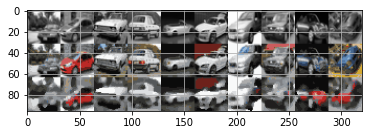

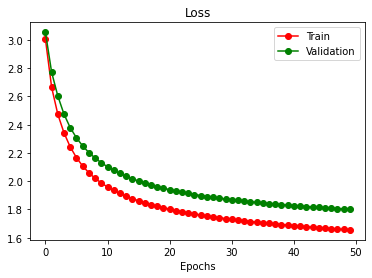

In [ ]:
##############################################################################################
#                                 define some arguments if needed to pass                    #
##############################################################################################

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()
args_dict = {
              'gpu':True, 
              'seed':400443232,
              'category_id': 1,
              'learning_rate':0.0001,
              'colours_dic_addr':'/content/drive/MyDrive/deep/car_colours_kmeans24.npy', 
              'model_mode':"base", 
              'experiment_name': 'base_model',
              'checkpoint': '/content/drive/MyDrive/deep/checkpoint/base_model.pth',
              'kernel':3,
              'num_filters':32, 
              'batch_size':100, 
              'num_colors': 24,
              'epochs':50, 
              'plot':True, 
              'visualize': False,
              'print_every':5,
              'downsize_input':False,
}
args.update(args_dict)

##############################################################################################
base_model = train(args)
##############################################################################################


In [ ]:
for name, param in base_model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

Complete the <code>model.py</code> to train your model

<br>

<p align="center">
  <img src="images/baseModel.png">
</p>

## Custom U-Net Model

Complete the <code>model.py</code> to train your model

### Training

File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Epoch [1/50]:	 Train Loss: 2.9572, Train accuracy: 13.9577
Epoch [1/50]:	 Valid Loss: 3.0145, Valid accuracy: 20.6269
Epoch [6/50]:	 Train Loss: 2.0866, Train accuracy: 34.3274
Epoch [6/50]:	 Valid Loss: 2.2253, Valid accuracy: 35.8317
Epoch [11/50]:	 Train Loss: 1.8544, Train accuracy: 39.0109
Epoch [11/50]:	 Valid Loss: 1.9868, Valid accuracy: 40.6417
Epoch [16/50]:	 Train Loss: 1.7342, Train accuracy: 41.5534
Epoch [16/50]:	 Valid Loss: 1.8650, Valid accuracy: 43.0051
Epoch [21/50]:	 Train Loss: 1.6586, Train accuracy: 43.1993
Epoch [21/50]:	 Valid Loss: 1.7906, Valid accuracy: 44.4346
Epoch [26/50]:	 Train Loss: 1.6051, Train accuracy: 44.4508
Epoch [26/50]:	 Valid Loss: 1.7389, Valid accuracy: 45.4831
Epoch [31/50]:	 Train Loss: 1.5638, Train accuracy: 45.4867
Epoch [31/50]:	 Valid Loss: 1.7005, Valid accuracy: 46.2647
Epoch [36/50]:	 Train Loss: 1.5296, Train accuracy: 46.3762
Epoch [36/50]:	 Valid Loss: 1.6698, Vali

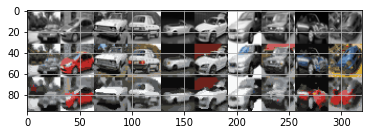

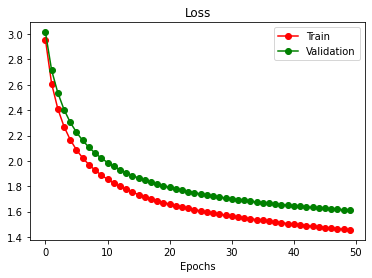

In [ ]:
##############################################################################################
#                                 define some arguments if needed to pass                    #
##############################################################################################

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()
# define other arguments if needed during training
args_dict = {
              'gpu':True, 
              'seed':400443232,
              'category_id': 1,
              'learning_rate':0.0001,
              'colours_dic_addr':'/content/drive/MyDrive/deep/car_colours_kmeans24.npy', 
              'model_mode':"unet", 
              'experiment_name': 'unet_model',
              'checkpoint': '/content/drive/MyDrive/deep/checkpoint/unet_model.pth',
              'kernel':3,
              'num_filters':32, 
              'batch_size':100, 
              'num_colors': 24,
              'epochs':50, 
              'plot':True, 
              'visualize': False,
              'print_every':5,
              'downsize_input':False,
}
args.update(args_dict)

##############################################################################################
unet_model = train(args)
##############################################################################################

# Refrences

- https://ai.stanford.edu/~syyeung/cvweb/tutorial1.html
- https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
- http://papers.nips.cc/paper/7515-how-does-batch-normalization-help-optimization.pdf
- Intro to optimization in deep learning: Busting the myth about batch normalization [[link](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/)]
- Why Does Batch Normalization Work? [[link](https://abay.tech/blog/2018/07/01/why-does-batch-normalization-work/)]
- https://arxiv.org/abs/1505.04597
